# Import

In [1]:
# System
import os
import json
import datetime

# Data processing
import numpy as np
from scipy.integrate import ode

# Plot
import matplotlib.pyplot as plt
from matplotlib import animation

# Config

In [2]:
config = {}

# Update config
    # Fpath
config.update({"Path_root": "/Volumes/Expansion/User_Backup/b08209033/111-2_DA"})
config.update({"Path_data": os.path.join(config["Path_root"], "data")})
config.update({"Path_src": os.path.join(config["Path_root"], "src")})
config.update({"Path_img": os.path.join(config["Path_root"], "img")})
    # Fname
config.update({"Fname_true_state": "x_t.npy"})
config.update({"Fname_analysis_state_init": "x_a_init.npy"})
config.update({"Fname_ensemble_analysis_state_init": "ensemble_x_a_init.npy"})

# Output config
os.chdir(config["Path_root"])
with open('config.json', 'w') as outfile:
    json.dump(config, outfile, sort_keys=True)

# Helper function

In [3]:
def jacobian(operator, x0, epsilon = 2e-8):
    J = np.zeros((x0.shape[0], operator(x0).shape[0]), dtype = "f8")
    for i in range(J.shape[0]):
        x = np.copy(x0)
        x[i] += epsilon
        f = operator(x) - operator(x0)
        for j in range(J.shape[1]):
            J[i,j] = f[j]/epsilon
    J = J.T
    return J

# Model Settings

In [4]:
# Simulation time and unit timestep
    # time length of the experiment
Tmax = 10
    # forecast-analysis cycle time length
    # CFL condition shall be considered
    # ***Due to implementation problem, plz make sure that Tmax and dT are evenly divisible
dT = 0.025
    # total time steps
nT = int(Tmax / dT) 
    # time index
background_time = np.linspace(0,10,nT+1)

## Lorenz96

In [5]:
# Lorenz 96 system 
N = 40              # number of grid points
F = 8.              # forcing term

### Reference

In [6]:
def lorenz96(t, y, F):
    """
    Lorenz96 model
    Following professor's time integration scheme
    """
    return (np.roll(y, -1) - np.roll(y, 2)) * np.roll(y, 1) - y + F

### Self-defined

In [7]:
def diff_eqs(x):
    """
    Lorenz96 model, governing equation
    """
    if (x.ndim == 2):
        dy = (np.roll(x, shift = -1, axis = 0)-np.roll(x, shift = 2, axis = 0))*np.roll(x, shift = 1, axis = 0) -x + 8
    elif (x.ndim == 3):
        dy = (np.roll(x, shift = -1, axis = 1)-np.roll(x, shift = 2, axis = 1))*np.roll(x, shift = 1, axis = 1) -x + 8
    else:
        dy = None
    return dy

In [8]:
# test = np.repeat(np.arange(40).reshape(-1,1)[np.newaxis], 20, axis = 0)
# print(diff_eqs(test)[0])
# print(diff_eqs(np.arange(40).reshape(-1,1)))

# Nature Run (Prof's)

## True state

In [9]:
def true_state_generator(system, forcing, grids, total_timestep, delta_t, fname, fpath):
    """
    Generate model trajectory based on parameters, and save as .txt with given format
    """
    # Parameter
    Tspinup = 100
    scaler = 0.1
    
    # Generate IC 
    random_IC = scaler*np.random.randn(grids)
    solver = ode(system).set_integrator('dopri5', nsteps=10000)
    solver.set_initial_value(random_IC, 0.).set_f_params(forcing)
    solver.integrate(Tspinup)
    true_state = np.array([solver.y], dtype='f8')
    
    # Generate full model trajectory
    solver = ode(system).set_integrator('dopri5')
    solver.set_initial_value(true_state[0], 0.).set_f_params(forcing)
    tt = 0 # current time step
    while solver.successful() and tt < total_timestep:
        solver.integrate(solver.t + delta_t)
        true_state = np.vstack([true_state, [solver.y]])
        tt += 1
    
    true_state = true_state.reshape(-1,grids,1)
    # Save
    os.chdir(fpath)
    np.save(fname, true_state)
    return true_state

In [10]:
# True state only need to generate once.
# Generate it if not existed, else read it.
if not os.path.exists(os.path.join(config["Path_data"], config["Fname_true_state"])):
    x_t_save = true_state_generator(system = lorenz96,
                                    forcing = F,
                                    grids = N,
                                    total_timestep = nT,
                                    delta_t = dT,
                                    fname = config["Fname_true_state"],
                                    fpath = config["Path_data"])
else:
    ticks = os.path.getmtime(os.path.join(config["Path_data"], config["Fname_true_state"]))
    realtime = datetime.datetime.fromtimestamp(ticks)
    print(f"True state had been generated.\nLast modified: {realtime}")
    os.chdir(config["Path_data"])
    x_t_save = np.load(config["Fname_true_state"])

True state had been generated.
Last modified: 2023-05-29 05:35:01.800000


## Analysis state (init)

In [11]:
def init_analysis_state_generator(system, forcing, grids, fname, fpath):
    """
    Generate random IC based on parameters, and save as .txt with given format
    """
    # Parameter
    Tspinup = 100
    scaler = 0.1
    
    # Generate IC 
    random_IC = scaler*np.random.randn(grids)
    solver = ode(system).set_integrator('dopri5', nsteps=10000)
    solver.set_initial_value(random_IC, 0.).set_f_params(forcing)
    solver.integrate(Tspinup)
    analysis_state = np.array([solver.y], dtype='f8').reshape(grids, 1)
    
    # Save
    os.chdir(fpath)
    np.save(fname, analysis_state)
    return analysis_state

In [12]:
# Random IC only need to generate once.
# Generate it if not existed, else read it.
if not os.path.exists(os.path.join(config["Path_data"], config["Fname_analysis_state_init"])):
    x_a_init = init_analysis_state_generator(system = lorenz96,
                                             forcing = F,
                                             grids = N,
                                             fname = config["Fname_analysis_state_init"],
                                             fpath = config["Path_data"])
else:
    ticks = os.path.getmtime(os.path.join(config["Path_data"], config["Fname_analysis_state_init"]))
    realtime = datetime.datetime.fromtimestamp(ticks)
    print(f"Initial analysis state had been generated.\nLast modified: {realtime}")
    os.chdir(config["Path_data"])
    x_a_init = np.load(config["Fname_analysis_state_init"])

Initial analysis state had been generated.
Last modified: 2023-05-29 05:35:02.230000


# Observation state & operator

In [13]:
class Observation_data():
    """
    WIP
    Note the list struct
    """
    def __init__(self, ref_data, ref_time):
        self.__reference_data = ref_data
        self.__reference_time = ref_time
        self.__observation_data = None
        self.__observation_time = None
        self.__LinObsOp = None
        self.__ObsOp = None
        self.__observation_error_std = None
        self.__observation_error_covariance = None
        
    def __time_coverage_scheme(self, opt = 1):
        """
        Define sub function, employ "time structure" of observation data
        Scheme:
        Full coverage (opt==1): each background correspond to one observation
        Sparse coverage (opt==2): Half background correspond to one observation, and observation are equally spaced
        Initial coverage (opt==3): Only first 30% background correspond to one observation
        General coverage (opt==4): About 68% background correspond to one observation, and observation are randomly scattered
        """
        def full_coverage():
            """
            Time structure of observation data
            All-time observation
            """
            return self.__reference_time
        def sparse_coverage():
            """
            Time structure of observation data
            Adjacent-spaced observation
            """
            return self.__reference_time[::4]
        def initial_coverage():
            """
            Time structure of observation data
            Only first 30% observation of all simulations
            """
            return self.__reference_time[:int(len(self.__reference_time)*.3)]
        def general_coverage(seed = 9527):
            """
            Time structure of observation data
            About 68% (std < +-1) observation, randomly scatter
            """
            # Deterministic seed
            np.random.seed(seed)
            # Randomness using normal distribution
            idx = np.abs(np.random.randn(len(self.__reference_time))) > 0.5
            return self.__reference_time[idx]
        
        # Choose scheme
        if (opt == 1):
            time = full_coverage()
        elif (opt == 2):
            time = sparse_coverage()
        elif (opt == 3):
            time = initial_coverage()
        elif (opt == 4):
            time = general_coverage()
        else:
            time = None
        self.__observation_time = time
        return time
    def __observation_operator_scheme(self, opt = 1):
        """
        Define sub function, employ "space structure" of observation data
        Scheme:
        Full observation (opt==1): All locations is observed at observation time
        Regular sparse observation (opt==2): Only 50% locations (with regular pattern) is observed at observation time
        Random sparse observation (opt==3): Only 80% locations (randomly chosen) is observed at observation time
        """
        def full_observation(dim = None):
            """
            Space structure of observation data
            All-locations observation
            """
            H = []
            for i in range(len(self.__observation_time)):
                observation_loc = np.full(dim, True)
                H.append(np.eye(dim)[observation_loc])
            return H 
        def regular_sparse_observation(dim = None):
            """
            Space structure of observation data
            Half-locations observation, with pattern (cyclic boundary)
            
            Pattern example, choose range = 15, location = 40
            1st valid time, 1-15 locations is observed
            2nd valid time, 16-30 locations is observed
            3rd valid time, 31-40 and 1-5 locations is observed
            
            In this case, the range and location is fixed
            range = 20
            location = 40
            """
            H = []
            for i in range(len(self.__observation_time)):
                observation_range = (((i)*int(dim/2))%dim ,((i+1)*int(dim/2)-1)%dim+1)          
                # Detect cyclic boundary is reached
                if (observation_range[0] > observation_range[1]):
                    observation_loc = np.full(dim, True)
                    observation_loc[observation_range[1]:observation_range[0]] = False
                else:
                    observation_loc = np.full(dim, False)
                    observation_loc[observation_range[0]:observation_range[1]] = True
                H.append(np.eye(dim)[observation_loc])  
            return H
        def random_sparse_observation(dim = None, seed = 9527):
            """
            Space structure of observation data
            80% locations observation, with pure randomness
            """
            # Deterministic outer seed
            np.random.seed(seed)
            deterministic_RNG = np.random.randint(int(1e6), size = len(self.__observation_time))
            #
            H = []
            for i in range(len(self.__observation_time)):
                # Deterministic inner seed
                np.random.seed(deterministic_RNG[i])
                #
                observation_loc = np.random.choice(a=[False, True], size=(dim), p=[0.5, 0.5])
                H.append(np.eye(dim)[observation_loc])
            return H
        def __Operator(H,x):
            """
            Define abstract(blueprint) of observation operator
            """
            return H@x
        def Operator(H, op = __Operator):
            """
            Create instance of observation operator
            """
            f = lambda x: op(H, x)
            return f
        def encapsulate_operator(H):
            """
            Create observation operator at each valid time
            """
            ObsOp = []
            for i in range(len(self.__observation_time)):
                f = Operator(H[i])
                ObsOp.append(f)
            return ObsOp
        
        input_dim = self.__reference_data[0].shape[0]
        if (opt == 1):
            H = full_observation(input_dim)
        elif (opt == 2):
            H = regular_sparse_observation(input_dim)
        elif (opt == 3):
            H = random_sparse_observation(input_dim)
        else:
            H = None
        ObsOp = encapsulate_operator(H)
        self.__LinObsOp = H
        self.__ObsOp = ObsOp
        return (H, ObsOp)
    def __reset_observation(self):
        """
        Reset observation to reference state, which is
        observation = ObsOp(reference), at valid time (following time scheme)
        """
        data = []
        for i in range(len(self.__observation_time)):
            ObsOp = self.__ObsOp[i]
            current_time = self.__observation_time[i]
            idx = np.argmin(np.abs(self.__reference_time-current_time))
            data.append(ObsOp(self.__reference_data[idx]))
        self.__observation_data = data
        return data
    def __random_error_scheme(self, std, opt = 1, seed = 9527):
        """
        Define sub function employ observation error following specific characteristic
        Scheme
        Pure RNG (opt==1): using scaled white noise
        """
        def PRNG(std, seed = 9527):
            """
            Generate error by white noise
            """
            # Deterministic outer seed
            np.random.seed(seed)
            deterministic_RNG = np.random.randint(int(1e6), size = len(self.__observation_time))
            #
            error = []
            R = []
            for i in range(len(self.__observation_data)):
                # Deterministic inner seed
                np.random.seed(deterministic_RNG[i])
                error.append(np.random.normal(loc = 0, scale = std, size = self.__observation_data[i].shape))
                R.append(np.eye(self.__observation_data[i].shape[0])*std**2)
            return (error, R)
        # Reset std
        self.__observation_error_std = std
        # Choose scheme
        if (opt == 1):
            error, R = PRNG(std = std, seed = seed)
        else:
            error = None
            R = None
        self.__observation_error_covariance = R
        return error
    def __fill_observation_error(self, error):
        """
        Adding observation error to observation data
        """
        for i in range(len(self.__observation_data)):
            self.__observation_data[i] += error[i]
        return self.__observation_data
    def generate(self, time_scheme = 1, space_scheme = 1, error_scheme = 1, std = 1):
        """
        Find valid time with observation
        Generate observation operator
        Reset observation
        Generate observation error
        Generate observation
        
        *** Compile sequence matters, dont move it!
        """
        time = self.__time_coverage_scheme(opt = time_scheme)
        ObsOp = self.__observation_operator_scheme(opt = space_scheme)
        data = self.__reset_observation()
        error = self.__random_error_scheme(std, opt = error_scheme)
        data = self.__fill_observation_error(error)
        return error
    
    def get_observation_data(self, time = None):
        """
        Currently support several methods.
        
        1. (default) Return full observation data
        2. Return single observation data, by given time
           Given time shall be a primitive number
        3. Return several observation data, by given time range
           Given time shall be a tuple, with 2 primitive number, represent start and end
        """
        # All-time
        if time is None:
            return self.__observation_data
        # Single-time
        elif (isinstance(time, int) or isinstance(time, float)):
            # Find closest observation
            idx = np.argmax(np.abs(self.__observation_time-time)<1e-4)
            diff = np.abs(self.__observation_time[idx]-time)
            # Check representativeness
            if (diff > 1e-3):
                return None
            else:
                return self.__observation_data[idx]
        # Several-time
        elif type(time) is tuple:
            # Find observation between 
            idx = np.logical_and(time[0] <= self.__observation_time, self.__observation_time <= time[1])
            # Check emptyness
            if (not idx.any()):
                return None
            else:
                idx = np.where(idx)[0]
                return [self.__observation_data[i] for i in idx]
        return None
    def get_observation_operator(self, time = None):
        """
        Currently support several methods.
        
        1. (default) Return full observation operator
        2. Return single observation operator, by given time
           Given time shall be a primitive number
        3. Return several observation operator, by given time range
           Given time shall be a tuple, with 2 primitive number, represent start and end
        """
        # All-time
        if time is None:
            return self.__ObsOp
        # Single-time
        elif (isinstance(time, int) or isinstance(time, float)):
            # Find closest observation
            idx = np.argmax(np.abs(self.__observation_time-time)<1e-4)
            diff = np.abs(self.__observation_time[idx]-time)
            # Check representativeness
            if (diff > 1e-3):
                return None
            else:
                return self.__ObsOp[idx]
        # Several-time
        elif type(time) is tuple:
            # Find observation between 
            idx = np.logical_and(time[0] <= self.__observation_time, self.__observation_time <= time[1])
            # Check emptyness
            if (not idx.any()):
                return None
            else:
                idx = np.where(idx)[0]
                return [self.__ObsOp[i] for i in idx]
        return None
    def get_observation_error_covariance(self, time = None):
        """
        Currently support several methods.
        
        1. (default) Return full observation error covariance
        2. Return single observation error covariance, by given time
           Given time shall be a primitive number
        3. Return several observation error covariance, by given time range
           Given time shall be a tuple, with 2 primitive number, represent start and end
        """
        # All-time
        if time is None:
            return self.__observation_error_covariance
        # Single-time
        elif (isinstance(time, int) or isinstance(time, float)):
            # Find closest observation
            idx = np.argmax(np.abs(self.__observation_time-time)<1e-4)
            diff = np.abs(self.__observation_time[idx]-time)
            # Check representativeness
            if (diff > 1e-3):
                return None
            else:
                return self.__observation_error_covariance[idx]
        # Several-time
        elif type(time) is tuple:
            # Find observation between 
            idx = np.logical_and(time[0] <= self.__observation_time, self.__observation_time <= time[1])
            # Check emptyness
            if (not idx.any()):
                return None
            else:
                idx = np.where(idx)[0]
                return [self.__observation_error_covariance[i] for i in idx]
        return None
    def get_observation_trajectory(self, loc = 0):
        x = self.get_observation_time()
        y = np.zeros(x.shape)
        for i in range(len(y)):
            is_observed = np.argwhere(self.__LinObsOp[i]==1)
            if (np.any(is_observed[:,1] == loc)):
                loc_t = int(np.argwhere(is_observed[:,1] == loc))
                y[i] = self.__observation_data[i][loc_t,-1]
            else:
                y[i] = np.nan
        return (x, y)
    def get_observation_time(self):
        return self.__observation_time
    def get_observation_error_std(self):
        return self.__observation_error_std

In [14]:
observation = Observation_data(ref_data = x_t_save, ref_time = background_time)
error = observation.generate(time_scheme = 1, space_scheme = 1, std = 2)


# Background Error Covariances

In [15]:
# B = R
B = np.eye(N) * observation.get_observation_error_std()**2

# Data Assimilation

## No DA

In [16]:
class Simulator_NoDA():
    def __init__(self,
                 x_a_init, 
                 x_b_init, 
                 BEC, 
                 observation, 
                 function, 
                 dT, 
                 nT):
        self.__x_a_init = x_a_init
        self.__x_b_init = x_b_init
        self.__B = BEC
        self.__observation = observation
        self.__func = function
        self.__dT = dT
        self.__nT = nT
        return None
    def __model(self, x):
        """
        Doing time integration using Runge-Kutta 4 scheme
        """
        k1 = self.__func(x)
        k2 = self.__func(x + k1*self.__dT/2)
        k3 = self.__func(x + (3*k1+k2)*self.__dT/16)
        k4 = self.__func(x + k3*self.__dT/2)
        k5 = self.__func(x + (-3*k2+6*k3+9*k4)*self.__dT/16)
        k6 = self.__func(x + (k1+4*k2+6*k3-12*k4+8*k5)*self.__dT/7)
        new_x = x + (self.__dT/90)*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)
        return new_x
    # def __model(self, x):
    #     """
    #     Doing time integration using Runge-Kutta 4 scheme
    #     """
    #     k1 = self.__func(x)
    #     k2 = self.__func(x + k1*self.__dT/2)
    #     k3 = self.__func(x + k2*self.__dT/2)
    #     k4 = self.__func(x + k3*self.__dT)
    #     new_x = x + (self.__dT/6)*(k1 + 2*k2 + 2*k3 + k4)
    #     return new_x
    def Cycle(self):
        observation = self.__observation
        x_b_all = self.__x_b_init[np.newaxis]
        x_a_all = self.__x_a_init[np.newaxis]
        ct = 0
        while ct < self.__nT:
            # Forecast
            x_b = self.__model(x_a_all[ct])[np.newaxis]
            x_b_all = np.vstack([x_b_all, x_b])
            # Analysis
            x_b = x_b_all[ct+1]
            y_o = observation.get_observation_data((ct+1)*self.__dT)
            R = observation.get_observation_error_covariance((ct+1)*self.__dT)
            H = observation.get_observation_operator((ct+1)*self.__dT)
            x_a = x_b[np.newaxis]
            x_a_all = np.vstack([x_a_all, x_a])
            # next
            ct += 1
        return x_a_all

In [17]:
Result_NoDA = Simulator_NoDA(x_a_init = x_a_init, 
                             x_b_init = np.full((N,1), np.nan, dtype="f8"),
                             BEC = B,
                             observation = observation, 
                             function = diff_eqs, 
                             dT = dT, 
                             nT = nT).Cycle()

## OI

In [18]:
class Simulator_OI():
    def __init__(self,
                 x_a_init, 
                 x_b_init,  
                 BEC, 
                 observation,
                 function, 
                 dT, 
                 nT):
        self.__x_a_init = x_a_init
        self.__x_b_init = x_b_init
        self.__observation = observation
        self.__B = BEC
        self.__Bi = np.linalg.inv(self.__B)
        self.__func = function
        self.__dT = dT
        self.__nT = nT
        return None
    def __model(self, x):
        """
        Doing time integration using Runge-Kutta 4 scheme
        """
        k1 = self.__func(x)
        k2 = self.__func(x + k1*self.__dT/2)
        k3 = self.__func(x + (3*k1+k2)*self.__dT/16)
        k4 = self.__func(x + k3*self.__dT/2)
        k5 = self.__func(x + (-3*k2+6*k3+9*k4)*self.__dT/16)
        k6 = self.__func(x + (k1+4*k2+6*k3-12*k4+8*k5)*self.__dT/7)
        new_x = x + (self.__dT/90)*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)
        return new_x
    def __OI(self, x_b, y_o, H, R):
        """
        Data assimilation using optimal interpolation
        """
        d = y_o - H(x_b)
        Hl = jacobian(H, x_b)
        Ri = np.linalg.inv(R)
        
        A = np.linalg.inv(self.__Bi + Hl.T@Ri@Hl)
        K = A@Hl.T@Ri
        x_a = x_b + K@d
        return x_a
    def Cycle(self):
        observation = self.__observation
        x_b_all = self.__x_b_init[np.newaxis]
        x_a_all = self.__x_a_init[np.newaxis]
        ct = 0
        while ct < self.__nT:
            # Forecast
            x_b = self.__model(x_a_all[ct])[np.newaxis]     
            x_b_all = np.vstack([x_b_all, x_b])
            # Analysis
            x_b = x_b_all[ct+1]
            y_o = observation.get_observation_data((ct+1)*self.__dT)
            H = observation.get_observation_operator((ct+1)*self.__dT)
            R = observation.get_observation_error_covariance((ct+1)*self.__dT)
            if y_o is not None:
                x_a = self.__OI(x_b, y_o, H, R)[np.newaxis]
                
            else:
                x_a = x_b[np.newaxis]
            x_a_all = np.vstack([x_a_all, x_a])
            # next
            ct += 1
        return x_a_all
    def NMC(self, x_a_all, inflation = 0.25):
        """
        Derive statistical BEC using NMC
        In this case, following Prof's advice, using
        Long forecast = 8 timestep
        Short forecast = 4 timestep
        By deduct different forecast at same valid time, expect the BEC structure
        can be revealed.
        """
        # Algorithm parameter
        long_forecast_length = 8
        short_forecast_length = 4
        forecast_length = long_forecast_length + 1
        N_samples = np.shape(x_a_all)[0]
        # Init
        samples = np.zeros((N_samples, forecast_length, np.shape(x_a_all)[-2], 1))
        # Forecast in each sampled analysis time
        for idx_samples in range(N_samples):
            current_x_b = x_a_all[idx_samples]
            samples[idx_samples,0] = current_x_b
            for idx_forecast in range(forecast_length-1):
                # Forecast
                new_x_b = self.__model(current_x_b)
                current_x_b = new_x_b
                
                samples[idx_samples,idx_forecast+1] = current_x_b
                
        # Deduct different forecast length at same valid time 
        
        samples_diff = samples[:-(long_forecast_length-short_forecast_length),long_forecast_length] - samples[(long_forecast_length-short_forecast_length):,short_forecast_length]
        # Calculate statistical BEC
        NMC_B = np.zeros((np.shape(x_a_all)[-2], np.shape(x_a_all)[-2]))
        for i in range(len(samples_diff)):
            d = samples_diff[i]
            NMC_B += (d@d.T/(np.shape(samples_diff)[0]-1))
        # Inflate
        NMC_B *= inflation
        return NMC_B
    def set_B(self, B):
        self.__B = B
        self.__Bi = np.linalg.inv(self.__B)
        return None
    def get_B(self):
        return self.__B

In [19]:
System = Simulator_OI(x_a_init = x_a_init, 
                      x_b_init = np.full((N,1), np.nan, dtype="f8"), 
                      BEC = B, 
                      observation = observation, 
                      function = diff_eqs, 
                      dT = dT, 
                      nT = nT)
Result_OI = System.Cycle()
NMC_B = System.NMC(Result_OI, inflation = 0.15)
System.set_B(NMC_B)
Result_ModOI = System.Cycle()

In [20]:
# arr = np.linspace(0.3,0.35, 11)
# for item in arr:
#     NMC_B = System.NMC(Result_OI, inflation = item)
#     System.set_B(NMC_B)
#     Result_ModOI = System.Cycle()
#     RMS = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_ModOI[:,:])))
#     print(f"RMS {RMS}, a {item}")

## 3DVar

In [21]:
class Simulator_3DVar():
    def __init__(self,
                 x_a_init, 
                 x_b_init, 
                 BEC,
                 observation,
                 function,
                 dT, 
                 nT):
        self.__x_a_init = x_a_init
        self.__x_b_init = x_b_init
        self.__observation = observation
        self.__B = BEC
        self.__Bi = np.linalg.inv(self.__B)
        self.__func = function
        self.__dT = dT
        self.__nT = nT
        return None
    def __model(self, x):
        """
        Doing time integration using Runge-Kutta 4 scheme
        """
        k1 = self.__func(x)
        k2 = self.__func(x + k1*self.__dT/2)
        k3 = self.__func(x + (3*k1+k2)*self.__dT/16)
        k4 = self.__func(x + k3*self.__dT/2)
        k5 = self.__func(x + (-3*k2+6*k3+9*k4)*self.__dT/16)
        k6 = self.__func(x + (k1+4*k2+6*k3-12*k4+8*k5)*self.__dT/7)
        new_x = x + (self.__dT/90)*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)
        return new_x
    def __increment_3DVar(self, x_b, y_o, H, Ri):
        def f(dx, x_a, x_b, d, Hl, Ri):
            """
            Cost function of 3DVar in incremental form
            """
            # Rename
            increment = dx
            past_state = x_a
            current_state = past_state + increment
            background_state = x_b
            innovation = d
            LinObsOp = Hl
            
            J_b = (1/2)*(current_state - background_state).T@self.__Bi@(current_state - background_state)
            J_o = (1/2)*(LinObsOp@increment - innovation).T@Ri@(LinObsOp@increment - innovation)
            J = J_b + J_o
            return J
        def fprime(dx, x_a, x_b, d, Hl, Ri):
            """
            Jacobian of cost function of 3DVar in incremental form
            """
            # Rename
            increment = dx
            past_state = x_a
            current_state = past_state + increment
            background_state = x_b
            innovation = d
            LinObsOp = Hl
            
            J_b = self.__Bi@(current_state - background_state)
            J_o = (LinObsOp.T)@Ri@(LinObsOp@increment - innovation)
            J = J_b + J_o
            return J
        def line_search(f, grad, dx, args = ()):
            """
            Modified from Golden Section Line Search
            Given object function, its gradient and reference state
            Find step (p_k) that minimize f, which is
            f(dx + p_k * grad) < f(dx)
            
            ***Still unstable due to ill-condition initial step size
            """
            # Algorithm parameter
            upper_bound = 1
            lower_bound = -1
            alpha = (3 - np.sqrt(5)) / 2
            # Initialize
            a0 = lower_bound
            b0 = upper_bound
            a1 = a0 + alpha*(b0-a0)
            b1 = b0 - alpha*(b0-a0)
            reference = f(dx, *args)
            
            # Find best step
            while True:
                result_a1 = f(dx+a1*grad, *args)
                result_b1 = f(dx+b1*grad, *args)
                if (result_a1 < reference):
                    best_p = a1
                    break
                if (result_b1 < reference):
                    best_p = b1
                    break
                if (result_a1 < result_b1):
                    b0 = b1
                    b1 = a1
                    a1 = a0 + alpha*(b0-a0)
                else:
                    a0 = a1
                    a1 = b1
                    b1 = b0 - alpha*(b0-a0)
            return best_p
        def PR_beta(g0, g1):
            """
            Polak-Ribiere method for conjugate gradient method 
            """
            return (g1.T@(g1-g0))/(g0.T@g0)
        def minimize(x_b, y_o, H, Ri):
            # Algorithm parameter
            maxiter_inner = int(1e6)
            maxiter_outer = int(1e6)
            # First guess, x = x_b
            x_a = np.copy(x_b)
            
            for out_loop in range(maxiter_outer):
                # Initial minimization parameter
                jac_old = np.full(np.shape(x_b), 0, dtype = "f8")
                jac_new = np.full(np.shape(x_b), 0, dtype = "f8")
                beta = None
                grad = 0
                # Initial increment
                dx = np.full(np.shape(x_b), 0, dtype = "f8")
                # Find current variable
                d = y_o - H(x_a)
                Hl = jacobian(H, x_a)
                
                # Control parameter
                args = (x_a, x_b, d, Hl, Ri)
                for in_loop in range(maxiter_inner):
                    # Find gradient
                    jac = fprime(dx, *args)
                    jac_new = jac
                    beta = PR_beta(jac_old, jac_new) if in_loop != 0 else 1
                    grad = -(jac_new) + beta*grad
                    jac_old = jac_new
                    # Find directions and step
                    p_k = line_search(f, grad, dx, args = args)
                    delta = p_k*grad
                    # Update dx
                    dx += delta
                    if (np.linalg.norm(delta) < 1e-4):
                        break
                # Update x
                x_a += dx
                if (np.linalg.norm(dx) < 1e-3):
                    break
            return x_a
        return minimize(x_b, y_o, H, Ri)  
        
    def Cycle(self):
        observation = self.__observation
        x_b_all = self.__x_b_init[np.newaxis]
        x_a_all = self.__x_a_init[np.newaxis]
        ct = 0
        while ct < self.__nT:
            # Forecast
            x_b = self.__model(x_a_all[ct])[np.newaxis]
            x_b_all = np.vstack([x_b_all, x_b])
            # Analysis
            x_b = x_b_all[ct+1]
            y_o = observation.get_observation_data((ct+1)*self.__dT)
            H = observation.get_observation_operator((ct+1)*self.__dT)
            R = observation.get_observation_error_covariance((ct+1)*self.__dT)
            
            if y_o is not None:
                Ri = np.linalg.inv(R)
                x_a = self.__increment_3DVar(x_b, y_o, H, Ri)[np.newaxis]
            else:
                x_a = x_b[np.newaxis]
            
            x_a_all = np.vstack([x_a_all, x_a])
            # next
            ct += 1
        return x_a_all
    def NMC(self, x_a_all, inflation = 0.25):
        """
        Derive statistical BEC using NMC
        In this case, following Prof's advice, using
        Long forecast = 8 timestep
        Short forecast = 4 timestep
        By deduct different forecast at same valid time, expect the BEC structure
        can be revealed.
        """
        # Algorithm parameter
        long_forecast_length = 8
        short_forecast_length = 4
        forecast_length = long_forecast_length + 1
        N_samples = np.shape(x_a_all)[0]
        # Init
        samples = np.zeros((N_samples, forecast_length, np.shape(x_a_all)[-2], 1))
        # Forecast in each sampled analysis time
        for idx_samples in range(N_samples):
            current_x_b = x_a_all[idx_samples]
            samples[idx_samples,0] = current_x_b
            for idx_forecast in range(forecast_length-1):
                # Forecast
                new_x_b = self.__model(current_x_b)
                current_x_b = new_x_b
                samples[idx_samples,idx_forecast+1] = current_x_b
        # Deduct different forecast length at same valid time 
        samples_diff = samples[:-(long_forecast_length-short_forecast_length),long_forecast_length] - samples[(long_forecast_length-short_forecast_length):,short_forecast_length]
        # Calculate statistical BEC
        NMC_B = np.zeros((np.shape(x_a_all)[-2], np.shape(x_a_all)[-2]))
        for i in range(len(samples_diff)):
            d = samples_diff[i]
            NMC_B += (d@d.T/(np.shape(samples_diff)[0]-1))
        # Inflate
        NMC_B *= inflation
        return NMC_B
    def set_B(self, B):
        self.__B = B
        self.__Bi = np.linalg.inv(self.__B)
        return None
    def get_B(self):
        return self.__B

In [22]:
System = Simulator_3DVar(x_a_init = x_a_init, 
                         x_b_init = np.full((N,1), np.nan, dtype="f8"),
                         BEC = B, 
                         observation = observation, 
                         function = diff_eqs, 
                         dT = dT, 
                         nT = nT)
Result_3DVar = System.Cycle()
NMC_B = System.NMC(Result_3DVar, inflation = 0.15)
System.set_B(NMC_B)
Result_Mod3DVar = System.Cycle()

## 4DVar

In [23]:
class Simulator_4DVar():
    def __init__(self,
                 x_a_init, 
                 x_b_init, 
                 BEC, 
                 observation,        
                 function, 
                 assimilation_window,
                 dT, 
                 nT):
        self.__x_a_init = x_a_init
        self.__x_b_init = x_b_init
        self.__observation = observation
        self.__B = BEC
        self.__Bi = np.linalg.inv(self.__B)
        self.__func = function
        self.__assimilation_window = assimilation_window
        self.__dT = dT
        self.__nT = nT
        return None
    def __model(self, x):
        """
        Doing time integration using Runge-Kutta 4 scheme
        """
        k1 = self.__func(x)
        k2 = self.__func(x + k1*self.__dT/2)
        k3 = self.__func(x + (3*k1+k2)*self.__dT/16)
        k4 = self.__func(x + k3*self.__dT/2)
        k5 = self.__func(x + (-3*k2+6*k3+9*k4)*self.__dT/16)
        k6 = self.__func(x + (k1+4*k2+6*k3-12*k4+8*k5)*self.__dT/7)
        new_x = x + (self.__dT/90)*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)
        return new_x
    def __increment_4DVar(self, x_b, y_o, H, R):
        def f(dx, x_a, x_b, d, Hl, M, Ri):
            """
            Cost function of 4DVar in incremental form
            """
            # Rename
            increment = dx
            past_state = x_a
            current_state = past_state + increment
            background_state = x_b
            innovation = d
            LinObsOp = Hl
            LinModelOp = M
            
            J_b = (1/2)*(current_state - background_state).T@self.__Bi@(current_state - background_state)
            J_o = 0
            for i in range(len(d)):
                J_o += (1/2)*(LinObsOp[i]@LinModelOp[i]@increment-innovation[i]).T@Ri[i]@(LinObsOp[i]@LinModelOp[i]@increment-innovation[i])
            J = J_b + J_o
            return J
        def fprime(dx, x_a, x_b, d, Hl, M, Ri):
            """
            Jacobian of cost function of 4DVar in incremental form
            """
            # Rename
            increment = dx
            past_state = x_a
            current_state = past_state + increment
            background_state = x_b
            innovation = d
            LinObsOp = Hl
            LinModelOp = M
            
            J_b = self.__Bi@(current_state - background_state)
            J_o = 0
            for i in range(len(y_o)):
                J_o += LinModelOp[i].T@LinObsOp[i].T@Ri[i]@(LinObsOp[i]@LinModelOp[i]@increment-innovation[i])
            
            J = J_b + J_o
            return J
        def line_search(f, grad, dx, args = ()):
            """
            Modified from Golden Section Line Search
            Given object function, its gradient and reference state
            Find step (p_k) that minimize f, which is
            f(dx + p_k * grad) < f(dx)
            
            ***Still unstable due to ill-condition initial step size
            """
            # Algorithm parameter
            upper_bound = 1
            lower_bound = -1
            alpha = (3 - np.sqrt(5)) / 2
            # Initialize
            a0 = lower_bound
            b0 = upper_bound
            a1 = a0 + alpha*(b0-a0)
            b1 = b0 - alpha*(b0-a0)
            reference = f(dx, *args)
            
            # Find best step
            while True:
                result_a1 = f(dx+a1*grad, *args)
                result_b1 = f(dx+b1*grad, *args)
                if (result_a1 < reference):
                    best_p = a1
                    break
                if (result_b1 < reference):
                    best_p = b1
                    break
                if (result_a1 < result_b1):
                    b0 = b1
                    b1 = a1
                    a1 = a0 + alpha*(b0-a0)
                else:
                    a0 = a1
                    a1 = b1
                    b1 = b0 - alpha*(b0-a0)
            return best_p
        def PR_beta(g0, g1):
            """
            Polak-Ribiere method for conjugate gradient method 
            """
            return (g1.T@(g1-g0))/(g0.T@g0)
        def minimize(x_b, y_o, H, R):
            # Algorithm parameter
            maxiter_inner = int(1e6)
            maxiter_outer = int(1e6)
            # First guess, x = x_b
            x_a = np.copy(x_b)
            for out_loop in range(maxiter_outer):
                # Initial minimization parameter
                jac_old = np.full(np.shape(x_b), 0, dtype = "f8")
                jac_new = np.full(np.shape(x_b), 0, dtype = "f8")
                beta = None
                grad = 0
                
                # Initial increment
                dx = np.full(np.shape(x_b), 0, dtype = "f8")
                # Initial model jacobian
                M = []
                M.append(np.eye(x_b.shape[0])) # The initial element is actually not jacobian
                # Initial model trajectory
                base_trajectory = []
                base_trajectory.append(x_a)
                # Initial observation operator jacobian
                Hl = []
                Hl.append(jacobian(H[0], base_trajectory[0]))
                # Initial innovation
                d = []
                d.append(y_o[0]-H[0](base_trajectory[0]))
                
                # Complete TLM (Tangent Linear Model)
                for i in range(len(y_o)-1):
                    M.append(jacobian(self.__model, base_trajectory[i]))
                    base_trajectory.append(self.__model(base_trajectory[i]))
                    d.append(y_o[i+1]-H[i+1](base_trajectory[i+1]))
                    Hl.append(jacobian(H[i+1], base_trajectory[i+1]))
                M = np.array(M, dtype = "f8")
                base_trajectory = np.array(base_trajectory, dtype = "f8")
                
                # Combine model operator
                for i in range(len(M)-1):
                    M[i+1] = M[i+1]@M[i]
                # 
                Ri = []
                for i in range(len(R)):
                    Ri.append(np.linalg.inv(R[i]))
                
                # Control parameter
                args = (x_a, x_b, d, Hl, M, Ri)
                for in_loop in range(maxiter_inner):
                    # Find gradient
                    jac = fprime(dx, *args)
                    jac_new = jac
                    beta = PR_beta(jac_old, jac_new) if in_loop != 0 else 1
                    grad = -(jac_new) + beta*grad     
                    jac_old = jac_new
                    p_k = line_search(f, grad, dx, args = args)
                    delta = p_k*grad
                    # Update dx
                    dx += delta
                    if (np.linalg.norm(delta) < 1e-2):
                        break
                # Update x
                x_a += dx
                if (np.linalg.norm(dx) < 1e-1):
                    break
            return x_a
        return minimize(x_b, y_o, H, R)  
        
    def Cycle(self):
        observation = self.__observation
        x_b_all = self.__x_b_init[np.newaxis]
        x_a_all = self.__x_a_init[np.newaxis]
        ct = 0
        used_observation_time = 0
        while ct < self.__nT:
            # print(ct*self.__dT)
            # Forecast
            x_b = self.__model(x_a_all[ct])[np.newaxis]
            x_b_all = np.vstack([x_b_all, x_b])
            # Analysis
            x_b = x_b_all[ct+1]
            if (used_observation_time>=(ct+1)*self.__dT):
                x_a = x_b[np.newaxis]
            else:
                args = ((ct+1)*self.__dT, (ct+self.__assimilation_window)*self.__dT)
                y_o = observation.get_observation_data(args)
                H = observation.get_observation_operator(args)
                R = observation.get_observation_error_covariance(args)
                if y_o is not None:
                    x_a = self.__increment_4DVar(x_b, y_o, H, R)[np.newaxis]
                    used_observation_time = (ct+self.__assimilation_window)*self.__dT
                else:
                    x_a = x_b[np.newaxis]
            x_a_all = np.vstack([x_a_all, x_a])
            # next
            ct += 1
        return x_a_all

In [24]:
System = Simulator_4DVar(x_a_init = x_a_init, 
                         x_b_init = np.full((N,1), np.nan, dtype="f8"),      
                         BEC = B, 
                         observation = observation,
                         function = diff_eqs,     
                         assimilation_window = 8,
                         dT = dT, 
                         nT = nT)
Result_4DVar = System.Cycle()

## EKF

In [25]:
class Simulator_EKF():
    def __init__(self,
                 x_a_init, 
                 x_b_init, 
                 BEC_init, 
                 observation, 
                 function, 
                 dT, 
                 nT):
        self.__x_a_init = x_a_init
        self.__x_b_init = x_b_init
        self.__observation = observation
        self.__B_init = BEC_init
        self.__func = function
        self.__dT = dT
        self.__nT = nT
        return None
    def __model(self, x):
        """
        Doing time integration using Runge-Kutta 4 scheme
        """
        k1 = self.__func(x)
        k2 = self.__func(x + k1*self.__dT/2)
        k3 = self.__func(x + (3*k1+k2)*self.__dT/16)
        k4 = self.__func(x + k3*self.__dT/2)
        k5 = self.__func(x + (-3*k2+6*k3+9*k4)*self.__dT/16)
        k6 = self.__func(x + (k1+4*k2+6*k3-12*k4+8*k5)*self.__dT/7)
        new_x = x + (self.__dT/90)*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)
        return new_x
    def __EKF_forecast(self, x_a, Ba):
        """
        Data assimilation using Extended Kalman Filter
        Forecast step
        """
        Q = 0
        M = jacobian(self.__model, x_a)
        Bf = M@Ba@M.T + Q
        return Bf
    def __EKF_analysis(self, x_b, y_o, H, Bf, R):
        """
        Data assimilation using Extended Kalman Filter
        Analysis step
        """
        d = y_o - H(x_b)
        Hl = jacobian(H, x_b)
        K = Bf@Hl.T@np.linalg.inv(Hl@Bf@Hl.T + R)
        x_a = x_b + K@d
        I = np.eye(len(x_b))
        Ba = (I - K@Hl)@Bf
        
        return x_a, Ba
    def __EKF_MUL_inflation(self, B, alpha = 1):
        return alpha*B
    def __EKF_ADD_inflation(self, Ba, alpha = 0):
        return Ba + np.eye(len(Ba))*alpha
    def __EKF_RTP_inflation(self, Ba, Bf, alpha = 0):
        return (1-alpha)*Ba + alpha*Bf
    def Cycle(self, MUL_param = 1, ADD_param = 0, RTP_param = 0):
        observation = self.__observation
        x_b_all = self.__x_b_init[np.newaxis]
        x_a_all = self.__x_a_init[np.newaxis]
        Bf = self.__B_init
        Ba = self.__B_init

        ct = 0
        while ct < self.__nT:
            
            # Forecast
            x_b = self.__model(x_a_all[ct])[np.newaxis]
            Bf = self.__EKF_forecast(x_a_all[ct], Ba)
            Bf = self.__EKF_MUL_inflation(Bf, alpha = MUL_param)
            x_b_all = np.vstack([x_b_all, x_b]) 
            # Analysis
            x_b = x_b_all[ct+1]
            y_o = observation.get_observation_data((ct+1)*self.__dT)
            H = observation.get_observation_operator((ct+1)*self.__dT)
            R = observation.get_observation_error_covariance((ct+1)*self.__dT)
            if y_o is not None:
                x_a, Ba = self.__EKF_analysis(x_b, y_o, H, Bf, R)
                x_a = x_a[np.newaxis]
                Ba = self.__EKF_RTP_inflation(Ba, Bf, alpha = RTP_param)
                Ba = self.__EKF_ADD_inflation(Ba, alpha = ADD_param)
                
            else:
                x_a = x_b[np.newaxis]
                Ba = Bf
            x_a_all = np.vstack([x_a_all, x_a])
            #
            ct += 1
        return x_a_all

In [26]:
System = Simulator_EKF(x_a_init = x_a_init, 
                       x_b_init = np.full((N,1), np.nan, dtype="f8"), 
                       BEC_init = B, 
                       observation = observation, 
                       function = diff_eqs, 
                       dT = dT, 
                       nT = nT)
Result_EKF = System.Cycle(MUL_param = 1.235, ADD_param = 0., RTP_param = 0.)

In [27]:
# def line_search(sys, tol = 1e-2):
#             sp = (3 - np.sqrt(5)) / 2
#             a0 = 1
#             b0 = 2
#             a1 = a0 + sp*(b0-a0)
#             b1 = b0 - sp*(b0-a0)
#             while abs(b0 - a0) > tol:
#                 Result_a1 = sys.Cycle(MUL_param = a1, ADD_param = 0., RTP_param = 0.)
#                 RMS_a1 = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_a1[:,:])))
#                 Result_b1 = sys.Cycle(MUL_param = b1, ADD_param = 0., RTP_param = 0.)
#                 RMS_b1 = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_b1[:,:])))
#                 if RMS_a1 < RMS_b1:
#                     b0 = b1
#                     b1 = a1
#                     a1 = a0 + sp*(b0-a0)
#                 else:
#                     a0 = a1
#                     a1 = b1
#                     b1 = b0 - sp*(b0-a0)
#             alpha = (a0 + b0)/2
#             return alpha
# test = line_search(System, tol = 1e-2)
# print(test)

## EnKF

### Ensemble IC

In [28]:
def ensemble_init_analysis_state_generator(system, forcing, grids, members, fname, fpath):
    """
    Generate random IC based on parameters, and save as .txt with given format
    """
    # Parameter
    Tspinup = 100
    scaler = 0.1
    
    #
    ensemble = []
    for i in range(members):
        if (i%20==0):
            print(i)
        # Generate IC 
        random_IC = scaler*np.random.randn(grids)
        solver = ode(system).set_integrator('dopri5', nsteps=10000)
        solver.set_initial_value(random_IC, 0.).set_f_params(forcing)
        solver.integrate(Tspinup)
        analysis_state = np.array([solver.y], dtype='f8').reshape(grids, 1)
        ensemble.append(analysis_state)
    ensemble = np.array(ensemble, dtype = "f8")
    # Save
    os.chdir(fpath)
    np.save(fname, ensemble)
    return ensemble

In [29]:
# Random IC only need to generate once.
# Generate it if not existed, else read it.
if not os.path.exists(os.path.join(config["Path_data"], config["Fname_ensemble_analysis_state_init"])):
    ensemble_x_a_init = ensemble_init_analysis_state_generator(system = lorenz96,
                                                               forcing = F,
                                                               grids = N,
                                                               members = 200,
                                                               fname = config["Fname_ensemble_analysis_state_init"],
                                                               fpath = config["Path_data"])
else:
    ticks = os.path.getmtime(os.path.join(config["Path_data"], config["Fname_ensemble_analysis_state_init"]))
    realtime = datetime.datetime.fromtimestamp(ticks)
    print(f"Initial ensemble analysis state had been generated.\nLast modified: {realtime}")
    os.chdir(config["Path_data"])
    ensemble_x_a_init = np.load(config["Fname_ensemble_analysis_state_init"])

0
20
40
60
80
100
120
140
160
180


### PO-EnKF

In [30]:
class Simulator_EnKF():
    def __init__(self,
                 x_a_init, 
                 x_b_init, 
                 observation, 
                 function, 
                 dT, 
                 nT):
        self.__x_a_init = x_a_init
        self.__x_b_init = x_b_init
        self.__observation = observation
        self.__func = function
        self.__dT = dT
        self.__nT = nT
        return None
    def __model(self, x):
        """
        Doing time integration using Runge-Kutta 4 scheme
        """
        k1 = self.__func(x)
        k2 = self.__func(x + k1*self.__dT/2)
        k3 = self.__func(x + (3*k1+k2)*self.__dT/16)
        k4 = self.__func(x + k3*self.__dT/2)
        k5 = self.__func(x + (-3*k2+6*k3+9*k4)*self.__dT/16)
        k6 = self.__func(x + (k1+4*k2+6*k3-12*k4+8*k5)*self.__dT/7)
        new_x = x + (self.__dT/90)*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)
        return new_x
    def __ensemble_mean(self, x):
        return np.mean(x, axis = 0)
    def __ensemble_BEC(self, x, x_mean):
        B = np.zeros((x_mean.shape[0], x_mean.shape[0]), dtype = "f8")
        for i in range(len(x)):
            B += (x[i]-x_mean)@(x[i]-x_mean).T
        B /= (len(x)-1)
        return B
    def __EnKF_analysis(self, x_b, x_b_mean, y_o, H, R, Bf):
        Hx = []
        for i in range(len(x_b)):
            Hx.append(H(x_b[i]))
        Hx = np.array(Hx, dtype = "f8")
        Hx_mean = self.__ensemble_mean(Hx)
        
        P_HlT = np.zeros((Bf.shape[0], R.shape[0]), dtype = "f8")
        for i in range(len(x_b)):
            P_HlT += (x_b[i]-x_b_mean)@(Hx[i]-Hx_mean).T
        P_HlT /= (len(x_b)-1)
        Hl_P_HlT = np.zeros((R.shape[0], R.shape[0]), dtype = "f8")
        for i in range(len(x_b)):
            Hl_P_HlT += (Hx[i]-Hx_mean)@(Hx[i]-Hx_mean).T
        Hl_P_HlT /= (len(x_b)-1)
        K = P_HlT@np.linalg.inv(Hl_P_HlT+R)
        
        x_a = []
        for i in range(len(x_b)):
            x_a.append(x_b[i]+K@(y_o[i]-Hx[i]))
        x_a = np.array(x_a, dtype = "f8")
        return x_a
    def __EnKF_B_localization(self, Bf, L = 30):
        for i in range(Bf.shape[0]):
            for j in range(Bf.shape[1]):
                Bf[i,j] *= np.exp((-(i-j)**2)/(2*L**2))
        return Bf
    def __EnKF_MUL_inflation(self, B, alpha = 1):
        return alpha*B
    def __EnKF_ADD_inflation(self, Ba, alpha = 0):
        return Ba + np.eye(len(Ba))*alpha
    def __EnKF_RTP_inflation(self, Ba, Bf, alpha = 0):
        return (1-alpha)*Ba + alpha*Bf
    def Cycle(self, Radius = 30, MUL_param = 1, ADD_param = 0, RTP_param = 0):
        observation = self.__observation
        x_b_all = self.__x_b_init[np.newaxis]
        x_b_mean_all = self.__ensemble_mean(self.__x_b_init)[np.newaxis]
        x_a_all = self.__x_a_init[np.newaxis]
        x_a_mean_all = self.__ensemble_mean(self.__x_a_init)[np.newaxis]
        Bf = self.__ensemble_BEC(x_b_all[-1], x_b_mean_all[-1])
        Ba = self.__ensemble_BEC(x_a_all[-1], x_a_mean_all[-1])
        
        ct = 0
        while ct < self.__nT:
            
            # Forecast
            x_b = self.__model(x_a_all[ct])[np.newaxis]
            x_b_mean = self.__ensemble_mean(x_b[0])[np.newaxis]
            Bf = self.__ensemble_BEC(x_b[0], x_b_mean_all[0])
            Bf = self.__EnKF_B_localization(Bf, Radius)
            Bf = self.__EnKF_MUL_inflation(Bf, alpha = MUL_param)
            x_b_all = np.vstack([x_b_all, x_b])
            x_b_mean_all = np.vstack([x_b_mean_all, x_b_mean])
            
            # Analysis
            x_b = x_b_all[ct+1]
            x_b_mean = x_b_mean_all[ct+1]
            y_o = observation.get_observation_data((ct+1)*self.__dT)
            H = observation.get_observation_operator((ct+1)*self.__dT)
            R = observation.get_observation_error_covariance((ct+1)*self.__dT)
            if y_o is not None:
                virtual_y_o = np.random.multivariate_normal(y_o.flatten(), R*(x_b_all.shape[1]-1)/x_b_all.shape[1], size = x_b_all.shape[1])[:,:,np.newaxis]
                x_a = self.__EnKF_analysis(x_b, x_b_mean, virtual_y_o, H, R, Bf)[np.newaxis]
                x_a_mean = self.__ensemble_mean(x_a[0])[np.newaxis]
                Ba = self.__ensemble_BEC(x_a[0], x_a_mean_all[0])
                Ba = self.__EnKF_RTP_inflation(Ba, Bf, alpha = RTP_param)
                Ba = self.__EnKF_ADD_inflation(Ba, alpha = ADD_param)
            else:
                x_a = x_b[np.newaxis]
                x_a_mean = x_b_mean[np.newaxis]
                Ba = Bf
            x_a_all = np.vstack([x_a_all, x_a])
            x_a_mean_all = np.vstack([x_a_mean_all, x_a_mean])
            #
            ct += 1
        return (x_b_all, x_b_mean_all), (x_a_all, x_a_mean_all)

In [45]:
System = Simulator_EnKF(x_a_init = ensemble_x_a_init, 
                        x_b_init = np.full(ensemble_x_a_init.shape, np.nan, dtype="f8"), 
                        observation = observation, 
                        function = diff_eqs, 
                        dT = dT, 
                        nT = nT)
Result_EnKF = System.Cycle(Radius = 13.67, MUL_param = 1.35, ADD_param = 0, RTP_param = 0.)

Background_Result_EnKF = Result_EnKF[0]
Analysis_Result_EnKF = Result_EnKF[1]

In [38]:
def line_search(sys, tol = 1e-2):
            sp = (3 - np.sqrt(5)) / 2
            a0 = 0
            b0 = 5
            a1 = a0 + sp*(b0-a0)
            b1 = b0 - sp*(b0-a0)
            while abs(b0 - a0) > tol:
                Result_a1 = sys.Cycle(Radius = 13.67, MUL_param = a1, ADD_param = 0, RTP_param = 0.)[1][1]
                RMS_a1 = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_a1[:,:])))
                Result_b1 = sys.Cycle(Radius = 13.67, MUL_param = b1, ADD_param = 0, RTP_param = 0.)[1][1]
                RMS_b1 = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_b1[:,:])))
                if RMS_a1 < RMS_b1:
                    b0 = b1
                    b1 = a1
                    a1 = a0 + sp*(b0-a0)
                else:
                    a0 = a1
                    a1 = b1
                    b1 = b0 - sp*(b0-a0)
            alpha = (a0 + b0)/2
            return alpha
test = line_search(System, tol = 1e-2)
print(test)

4.137820896649712


# Plot

## Observation error properties

In [33]:
# fig, axes = plt.subplots(nrows = 4,
#                          ncols = 10,
#                          figsize = (30,12),
#                          dpi = 100)
# for i, ax in enumerate(axes.flatten()):
#     ax.hist(np.array(error)[:,i,:], density = True)
#     ax.plot([np.mean(np.array(error)[:,i,:]),np.mean(np.array(error)[:,i,:])],[0,1], "k", linewidth = 3)
#     ax.set_ylim(0,0.3)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_title(f"loc = {i:2d}", size = 24)
# fig.suptitle(f"T = {Tmax}, dT = {dT}\nSamples = {nT+1}", size = 24)
# plt.savefig("Observation_distribution.png")
# plt.show()

In [34]:
# statistical_R = np.zeros((N,N))
# for i in range(len(error)):
#     eta = np.array(error)[i,:,:]
#     statistical_R += eta@eta.T
# statistical_R /= len(error)
# plt.figure(figsize = (10,8),
#            dpi = 100)
# plt.pcolormesh(NMC_B)
# plt.colorbar()
# plt.title("Background Error Covariance")
# plt.savefig("NMC_BEC.png")
# plt.show()

## RMSE at each locations

In [35]:
# RMS_NoDA = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_NoDA[:,:]), axis = 0))
# RMS_OI = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_OI[:,:]), axis = 0))
# # RMS_ModOI = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_ModOI[:,:]), axis = 0))
# RMS_3DVar = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_3DVar[:,:]), axis = 0))
# # RMS_Mod3DVar = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_Mod3DVar[:,:]), axis = 0))
# RMS_4DVar = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_4DVar[:,:]), axis = 0))
# RMS_EKF = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_EKF[:,:]), axis = 0))

# plt.figure(figsize = (15, 6), 
#            dpi = 150)
# plt.plot(RMS_NoDA, label = "NoDA")
# plt.plot(RMS_OI, label = "OI", linewidth = 3)
# # plt.plot(RMS_ModOI, label = "ModOI", linewidth = 3)
# plt.plot(RMS_3DVar, label = "3DVar")
# # plt.plot(RMS_Mod3DVar, label = "Mod3DVar")
# plt.plot(RMS_4DVar, label = "4DVar")
# plt.plot(RMS_EKF, label = "EKF")
# plt.legend(loc = 1)
# plt.show()

## Single point, time series

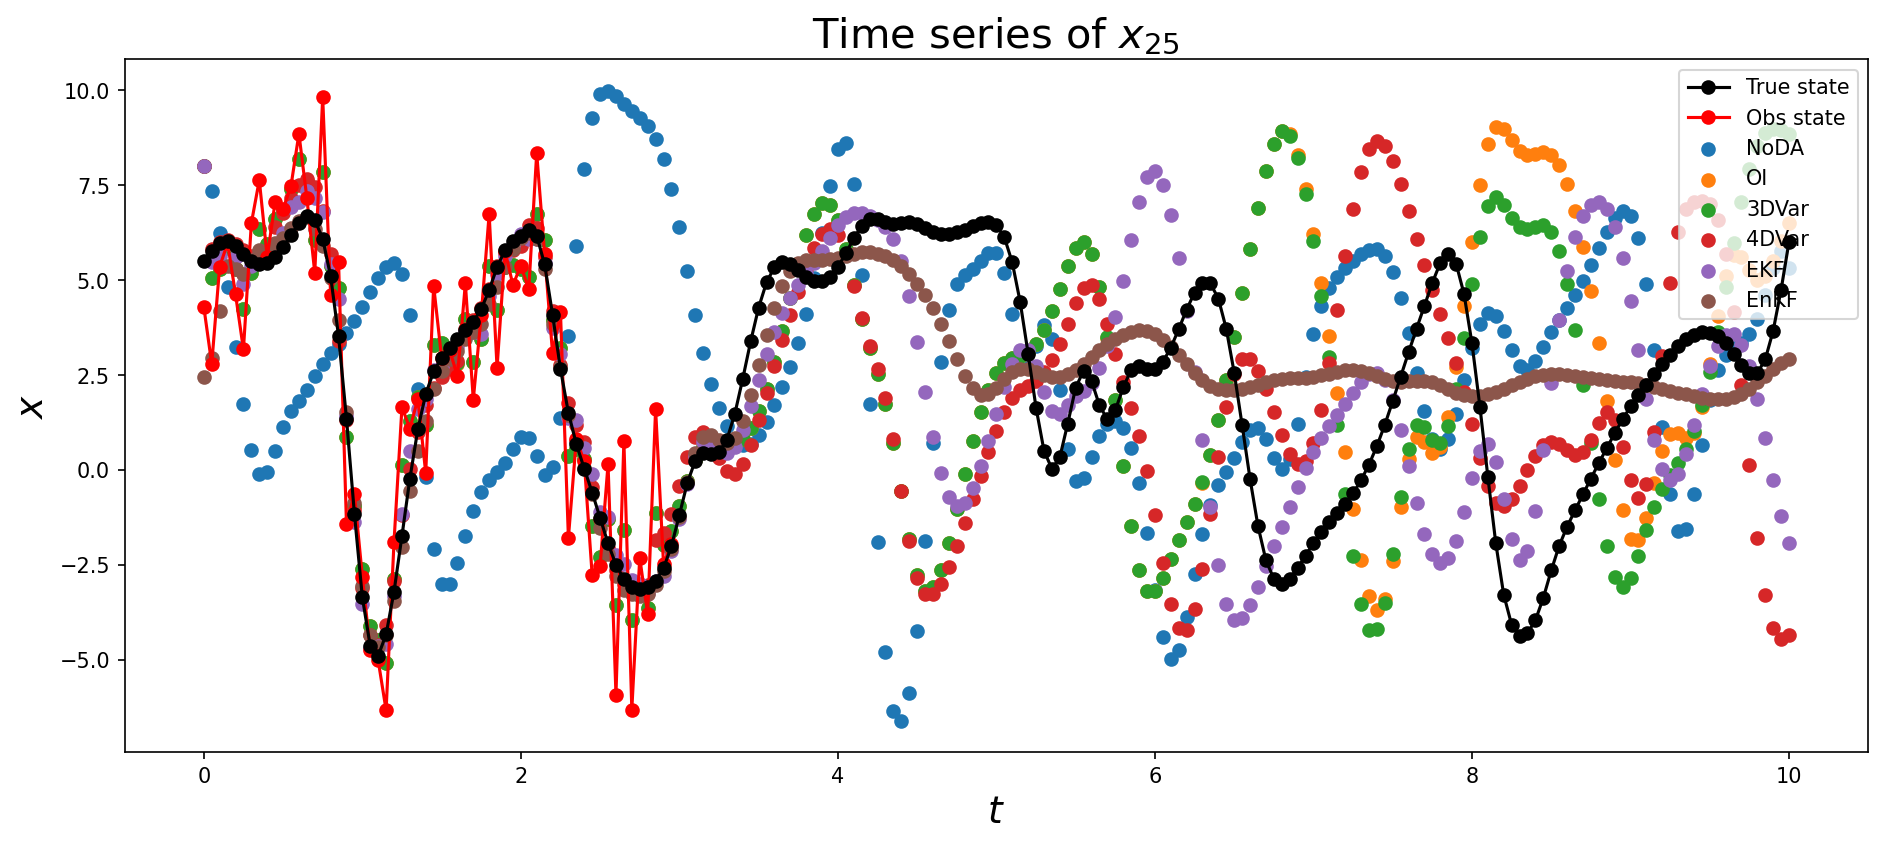

In [46]:
# Plot time series of a single grid point
pt = 25
# pt = 4
observation_locN = observation.get_observation_trajectory(pt)
time_series = np.arange(nT+1) * dT

plt.figure(figsize = (15, 6), 
           dpi = 150)
plt.plot(time_series, x_t_save[:,pt], 'ko-', label="True state", zorder = 15)
plt.plot(observation_locN[0], observation_locN[1], 'ro-', label="Obs state", zorder = 10)
plt.scatter(time_series, Result_NoDA[:,pt], label="NoDA")
plt.scatter(time_series, Result_OI[:,pt] , label="OI")
#plt.scatter(time_series, Result_ModOI[:,pt] , label="OI-NMC")
plt.scatter(time_series, Result_3DVar[:,pt], label="3DVar")
#plt.scatter(time_series, Result_Mod3DVar[:,pt] , label="3DVar-NMC")
plt.scatter(time_series, Result_4DVar[:,pt], label="4DVar")
plt.scatter(time_series, Result_EKF[:,pt] , label="EKF")
plt.scatter(time_series, Analysis_Result_EnKF[1][:,pt] , label="EnKF")

plt.xlabel(r'$t$', size=18)
plt.ylabel(r'$x$', size=18)
plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
plt.legend(loc='upper right', numpoints=1)
plt.savefig('timeseries.png')
plt.show()

## RMSE and Bias

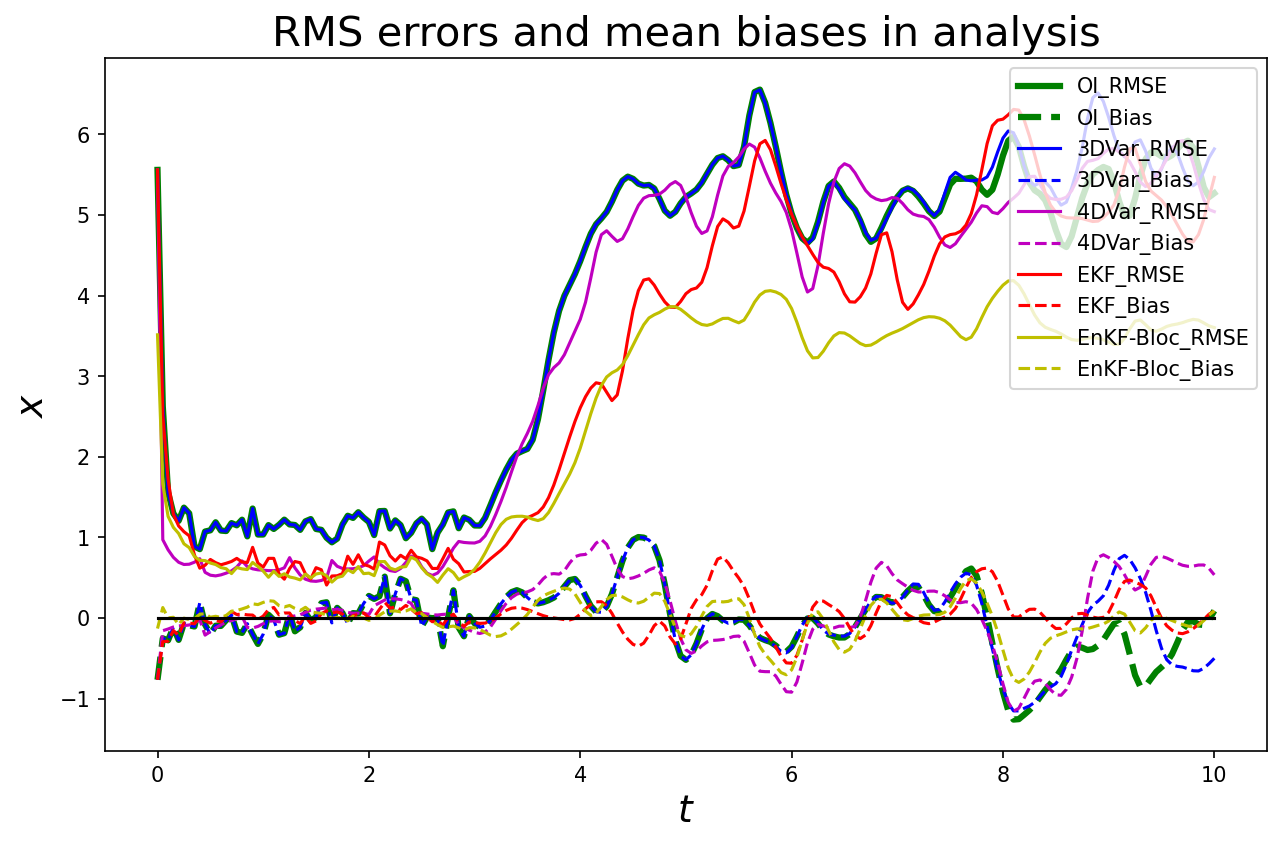

In [47]:
RMS_NoDA = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_NoDA[:,:]), axis = 1))
Bias_NoDA = np.mean(x_t_save[:,:]-Result_NoDA[:,:], axis = 1)

RMS_OI = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_OI[:,:]), axis = 1))
Bias_OI = np.mean(x_t_save[:,:]-Result_OI[:,:], axis = 1)

RMS_ModOI = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_ModOI[:,:]), axis = 1))
Bias_ModOI = np.mean(x_t_save[:,:]-Result_ModOI[:,:], axis = 1)

RMS_3DVar = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_3DVar[:,:]), axis = 1))
Bias_3DVar = np.mean(x_t_save[:,:]-Result_3DVar[:,:], axis = 1)

RMS_Mod3DVar = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_Mod3DVar[:,:]), axis = 1))
Bias_Mod3DVar = np.mean(x_t_save[:,:]-Result_Mod3DVar[:,:], axis = 1)

RMS_4DVar = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_4DVar[:,:]), axis = 1))
Bias_4DVar = np.mean(x_t_save[:,:]-Result_4DVar[:,:], axis = 1)

RMS_EKF = np.sqrt(np.mean(np.square(x_t_save[:,:]-Result_EKF[:,:]), axis = 1))
Bias_EKF = np.mean(x_t_save[:,:]-Result_EKF[:,:], axis = 1)

RMS_EnKF = np.sqrt(np.mean(np.square(x_t_save[:,:]-Analysis_Result_EnKF[1][:,:]), axis = 1))
Bias_EnKF = np.mean(x_t_save[:,:]-Analysis_Result_EnKF[1][:,:], axis = 1)

time_series = np.arange(nT+1) * dT

plt.figure(figsize = (10, 6), 
           dpi = 150)

# plt.plot(time_series, RMS_NoDA, "g-", label="NoDA_RMSE")
# plt.plot(time_series, Bias_NoDA, "g--", label="NoDA_Bias")

plt.plot(time_series, RMS_OI, "g-", linewidth = 3, label="OI_RMSE")
plt.plot(time_series, Bias_OI, "g--", linewidth = 3, label="OI_Bias")

# plt.plot(time_series, RMS_ModOI, "g-", linewidth = 3, label=r"OI-NMC($\alpha$=0.15)_RMSE")
# plt.plot(time_series, Bias_ModOI, "g--", linewidth = 3, label=r"OI-NMC($\alpha$=0.15)_Bias")

plt.plot(time_series, RMS_3DVar, "b-", label="3DVar_RMSE")
plt.plot(time_series, Bias_3DVar, "b--", label="3DVar_Bias")

# plt.plot(time_series, RMS_Mod3DVar, "b-", label=r"3DVar-NMC($\alpha$=0.15)_RMSE")
# plt.plot(time_series, Bias_Mod3DVar, "b--", label=r"3DVar-NMC($\alpha$=0.15)_Bias")

plt.plot(time_series, RMS_4DVar, "m-", label="4DVar_RMSE")
plt.plot(time_series, Bias_4DVar, "m--", label="4DVar_Bias")

plt.plot(time_series, RMS_EKF, "r-", label="EKF_RMSE")
plt.plot(time_series, Bias_EKF, "r--", label="EKF_Bias")

plt.plot(time_series, RMS_EnKF, "y-", label="EnKF-Bloc_RMSE")
plt.plot(time_series, Bias_EnKF, "y--", label="EnKF-Bloc_Bias")



plt.plot(time_series, np.zeros(np.shape(time_series)), "k-")
plt.xlabel(r'$t$', size=18)
plt.ylabel(r'$x$', size=18)
plt.title(r'RMS errors and mean biases in analysis', size=20)
plt.legend(loc='upper right', numpoints=1)
plt.savefig("Comparison.png")
plt.show()